# Prediction Model

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_pickle('./tmp/df_cleaned.gzip')


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5258 entries, 6 to 6715
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   BuildingType            5258 non-null   object 
 1   PrimaryPropertyType     5258 non-null   object 
 2   Neighborhood            5258 non-null   object 
 3   NumberofFloors          5258 non-null   float64
 4   PropertyGFATotal        5258 non-null   float64
 5   LargestPropertyUseType  5145 non-null   object 
 6   ENERGYSTARScore         3990 non-null   float64
 7   SourceEUI(kBtu/sf)      5258 non-null   float64
 8   SiteEnergyUse(kBtu)     5258 non-null   float64
 9   TotalGHGEmissions       5258 non-null   float64
 10  GHGEmissionsIntensity   4993 non-null   float64
 11  BuildingAge             5258 non-null   int64  
 12  Distance                5258 non-null   float64
 13  NaturalGasRate          5030 non-null   float64
dtypes: float64(9), int64(1), object(4)
memor

In [4]:
# on regarde simplement quelles sont les formes des features
feats = pd.DataFrame(
    columns=['feature', 'std', 'skew', 'var', 'kur']
)
agg_func = ['std', 'skew', 'var', 'kurtosis']

for f in df.select_dtypes(['float', 'int']):
    res = df[f].agg(agg_func)
    feats = feats.append(
        {'feature': f, 'std': res[0], 'skew': res[1],
            'var': res[2], 'kur': res[3]},
        ignore_index=True)

feats


,feature,std,skew,var,kur
0,NumberofFloors,1.788847e+00,0.370497,3.199974e+00,-0.162327
1,PropertyGFATotal,3.375187e+04,1.613754,1.139189e+09,2.095403
2,ENERGYSTARScore,2.630903e+01,-0.864708,6.921651e+02,-0.174476
3,SourceEUI(kBtu/sf),4.788165e+01,0.566472,2.292653e+03,0.803034
4,SiteEnergyUse(kBtu),1.588217e+06,1.636281,2.522434e+12,2.658183
5,TotalGHGEmissions,4.364218e+01,1.637797,1.904640e+03,2.365759
6,GHGEmissionsIntensity,6.982601e-01,1.391196,4.875671e-01,1.197036
7,BuildingAge,3.310015e+01,0.476128,1.095620e+03,-0.974226
8,Distance,2.215590e+00,0.777645,4.908837e+00,-0.321226
9,NaturalGasRate,2.701517e-01,0.755802,7.298195e-02,-0.657682


## Predition Function

In [5]:

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from datetime import datetime


prediction = 'TotalGHGEmissions'
removed_features = 'ENERGYSTARScore'

X = df.drop([prediction, removed_features], axis=1)
y = df[prediction]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)


def runModel(
    model, 
    params={},
    pre_processing_steps = [
                ("imputer", SimpleImputer()),
                ("scaler", StandardScaler(with_mean=False))
            ]
    ):
    start_time = datetime.now()
    # categorical features : they are only nominal (not cardinal),
    # thus we could encode them with OneHotEncoder (not OrdinalEncoder)
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")


    numeric_transformer = Pipeline(
        steps = pre_processing_steps
    )
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, selector(dtype_exclude="object")),
            ("cat", categorical_transformer, selector(dtype_include="object"))
        ]
    )

    reg = Pipeline(
        steps=[("preprocessor", preprocessor), ("regressor", model)]
    )

    reg.fit(X_train, y_train)

    # by default, add a parameter for imputer, for all model's grid search
    # params["preprocessor__num__imputer__strategy"] = ["mean", "median"]

    gs = GridSearchCV(
        estimator=reg,
        cv=5,
        param_grid=params,
        scoring=('r2', 'neg_mean_absolute_error'),
        refit='r2',
        return_train_score=True,
        n_jobs=-1
    )

    gs.fit(X_train, y_train)
    end_time = datetime.now()

    ellapsed_time = (end_time - start_time).total_seconds()
    y_pred = gs.predict(X_test)

    ret = {
        'model': type(model).__name__,
        'compute_time': ellapsed_time,
        'best_params': gs.best_params_,
        'RMSE': np.sqrt(mean_squared_error(y_pred, y_test)),
        'MAE': mean_absolute_error(y_pred, y_test),
        'R2': r2_score(y_pred, y_test),
        'cv_results': gs.cv_results_,
        'model_train_score': gs.score(X_train, y_train),
        'model_test_score': gs.score(X_test, y_test)
    }

    # TODO print validation curve : https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py

    return ret


In [6]:

# Dummy regressor as for testing
runModel(DummyRegressor(strategy="mean"));


## Preprocessing Optimization

We use a simple Linear Regression to assess what are the best pre processing steps to consider: which ones optimizes our results

In [7]:
# Regressor as a baseline

# res_baseline = pd.DataFrame(
#     columns=['testcase', 'model', 'compute_time', 'best_params', 'RMSE', 'MAE',
#              'R2', 'cv_results', 'model_train_score', 'model_test_score']
# )

def best_preprocessing_params():
    parameters = {
        # "preprocessor__num__imputer__strategy" : ["mean", "median"]
        "preprocessor__num__imputer__strategy" : ["mean"]
    }

    model = LinearRegression()

    ret0 = runModel(model, parameters)
    ret0['testcase'] = 'No preprocessing'

    ret1 = runModel(model, parameters, [("imputer", SimpleImputer())])
    ret1['testcase'] = 'SimpleImputer only'

    ret2 = runModel(model, parameters, [("imputer", SimpleImputer()), ("minmax", MinMaxScaler())])
    ret2['testcase'] = 'SimpleImputer + MinMax'

    ret3 = runModel(model, parameters, [("imputer", SimpleImputer()), ("minmax", MinMaxScaler()), ("scaler", StandardScaler(with_mean=False))])
    ret3['testcase'] = 'SimpleImputer + Minmax + StdScaler'

    ret4 = runModel(model, parameters, [("imputer", SimpleImputer()), ("scaler", StandardScaler(with_mean=False))])
    ret4['testcase'] = 'SimpleImputer + StdScaler'

    ret5 = runModel(model, parameters, [("imputer", SimpleImputer()), ("scaler", StandardScaler())])
    ret5['testcase'] = 'SimpleImputer + StdScaler(w/ mean)'

    res_baseline = pd.DataFrame.from_dict([ret1, ret2, ret3, ret4, ret5])

    # res_baseline = res_baseline.append(ret1, ignore_index=True)
    # res_baseline = res_baseline.append(ret2, ignore_index=True)
    # res_baseline = res_baseline.append(ret3, ignore_index=True)
    # res_baseline = res_baseline.append(ret4, ignore_index=True)
    # res_baseline = res_baseline.append(ret5, ignore_index=True)

    # res_baseline.T
    res_baseline_draw = res_baseline.set_index('testcase')
    # Clear dataframe for successive runs
    # res_baseline.drop(res_baseline.index, inplace=True)
    return res_baseline_draw


# need to compute several times, since we have side effects on memory allocation on jupyter notebooks at firsts launches, which produces biased / false results for compute time (difference is very small)
res_baseline_draw = best_preprocessing_params()
for i in range(5):
    res_baseline_draw = res_baseline_draw.append(best_preprocessing_params())
    # res_baseline_draw = best_preprocessing_params()

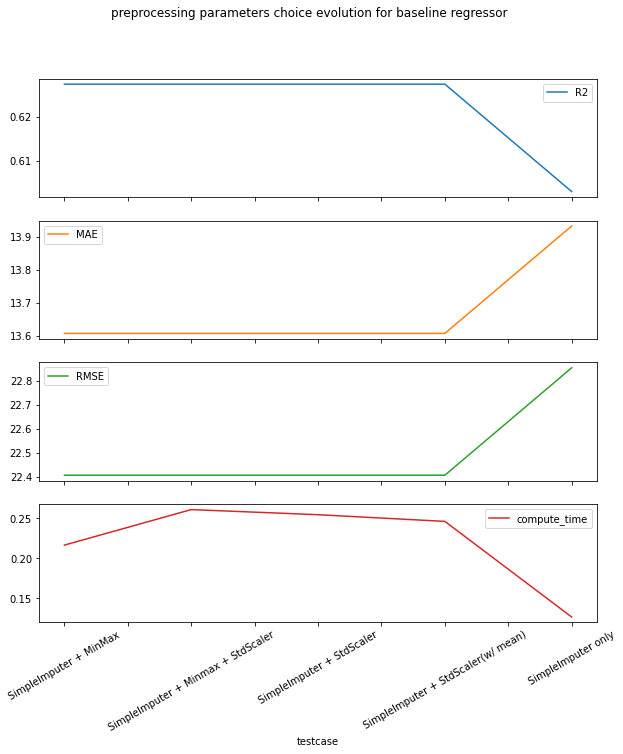

In [8]:
res_baseline_draw[['R2', 'MAE', 'RMSE', 'compute_time']].groupby(level=0).mean().plot(rot=30, kind='line',  subplots=True, figsize=(10, 10), 
    title='preprocessing parameters choice evolution for baseline regressor');

SimpleImputer is mandatory, otherwise we have errors of missing values for training the model

Then, in order to reduce the error & raise the score, we have to choose at least a StandardScaler or a MinMax (both at the same time are not providing a significant improvement, with a slight increase in compute time)

> We choose to keep SimpleImputer + StdScaler (w/mean), which provides a slightly shorter compute time, for the same benefit

## Models compute

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
import xgboost as xgb
from xgboost import XGBRegressor
import os
from dataclasses import dataclass
from datetime import datetime

xgb.set_config(verbosity=0)


@dataclass
class ModelCompute:
    model: object
    params: dict



In [10]:

hyper_params_baseline = dict()

hyper_params_baseline['parameters_svr'] = {
    # 'regressor__C': np.logspace(-2, -1, 10),
    # 'regressor__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
}

hyper_params_baseline['parameters_rf'] = {
    # 'regressor__n_estimators': [10, 50, 100, 300, 500],
    # 'regressor__min_samples_leaf': [1, 3, 5, 10],
    # 'regressor__max_features': ['auto', 'sqrt', 'log2'],

    # 'regressor__max_depth' : [5, 15, 25, 50],
    # 'regressor__min_samples_split': [2, 5, 10],
    # 'regressor__bootstrap' : [True, False],
}

hyper_params_baseline['parameters_knn'] = {
    # 'regressor__n_neighbors': [2, 4, 8, 10, 16]
}

hyper_params_baseline['parameters_xgb'] = {
    'regressor__n_estimators': [10],
    # 'regressor__n_estimators': [200, 500, 1000],
    # 'regressor__max_depth': [2, 5, 10],
    # 'regressor__eval_metric': ["rmse"],
}

hyper_params_baseline['parameters_ridge'] = {
    # 'regressor__alpha': np.logspace(-5, 5, 100)
}

hyper_params_baseline['parameters_lasso'] = {
    # 'regressor__alpha': np.logspace(-5, 5, 50)
}

hyper_params_baseline['parameters_net'] = {
    # 'regressor__alpha': np.logspace(-5, 5, 50),
    # 'regressor__l1_ratio' : np.logspace(-5, 5, 200),
}

hyper_params = hyper_params_baseline

models = [
    # ModelCompute(DummyRegressor(strategy="mean"), {}),
    ModelCompute(LinearRegression(n_jobs=os.cpu_count()), {}),
    ModelCompute(KNeighborsRegressor(), hyper_params['parameters_knn']),
    ModelCompute(RandomForestRegressor(n_jobs=os.cpu_count()), hyper_params['parameters_rf']),
    ModelCompute(XGBRegressor(n_jobs=os.cpu_count()), hyper_params['parameters_xgb']),
    ModelCompute(LinearSVR(), hyper_params['parameters_svr']),
    ModelCompute(Ridge(), hyper_params['parameters_ridge']),
    ModelCompute(Lasso(tol=1000), hyper_params['parameters_lasso']),
    ModelCompute(ElasticNet(tol=1000), hyper_params['parameters_net'])
]

results = pd.DataFrame(
    columns=['model', 'compute_time', 'best_params', 'RMSE', 'MAE',
             'R2', 'cv_results', 'model_train_score', 'model_test_score']
)

print(f'computing models with {os.cpu_count()} cpus')

start_time = datetime.now()
for mod in models:
    print(f'computing model {type(mod.model).__name__}...', end='')
    ret = runModel(mod.model, mod.params)
    results = results.append(ret, ignore_index=True)
    print('done.')
print(f'finished compute models in {datetime.now() - start_time}')

results.T



computing models with 32 cpus
computing model LinearRegression...done.
computing model KNeighborsRegressor...done.
computing model RandomForestRegressor...done.
computing model XGBRegressor...done.
computing model LinearSVR...done.
computing model Ridge...done.
computing model Lasso...done.
computing model ElasticNet...done.
finished compute models in 0:00:32.137141


,0,1,2,3,4,5,6,7
model,LinearRegression,KNeighborsRegressor,RandomForestRegressor,XGBRegressor,LinearSVR,Ridge,Lasso,ElasticNet
compute_time,0.233554,0.726867,2.352847,27.332363,0.101206,0.10288,0.073405,0.068987
best_params,{},{},{},{'regressor__n_estimators': 10},{},{},{},{}
RMSE,22.407271,16.620846,5.229883,6.927811,23.504608,22.514036,26.287411,25.257806
MAE,13.607949,8.69385,2.083069,3.226395,12.581388,13.650346,16.624253,14.558238
R2,0.627479,0.803643,0.985003,0.972008,0.485762,0.618408,0.589345,0.388702
cv_results,"{'mean_fit_time': [0.06434793472290039], 'std_...","{'mean_fit_time': [0.0130767822265625], 'std_f...","{'mean_fit_time': [1.2707673072814942], 'std_f...","{'mean_fit_time': [19.744531869888306], 'std_f...","{'mean_fit_time': [0.022910547256469727], 'std...","{'mean_fit_time': [0.024497842788696288], 'std...","{'mean_fit_time': [0.0161649227142334], 'std_f...","{'mean_fit_time': [0.015032434463500976], 'std..."
model_train_score,0.739409,0.892259,0.996429,0.985135,0.692289,0.736686,0.638371,0.669658
model_test_score,0.734561,0.853953,0.98554,0.974627,0.707926,0.732026,0.634672,0.66273


In [11]:
results


,model,compute_time,best_params,RMSE,MAE,R2,cv_results,model_train_score,model_test_score
0,LinearRegression,0.233554,{},22.407271,13.607949,0.627479,"{'mean_fit_time': [0.06434793472290039], 'std_...",0.739409,0.734561
1,KNeighborsRegressor,0.726867,{},16.620846,8.693850,0.803643,"{'mean_fit_time': [0.0130767822265625], 'std_f...",0.892259,0.853953
2,RandomForestRegressor,2.352847,{},5.229883,2.083069,0.985003,"{'mean_fit_time': [1.2707673072814942], 'std_f...",0.996429,0.985540
3,XGBRegressor,27.332363,{'regressor__n_estimators': 10},6.927811,3.226395,0.972008,"{'mean_fit_time': [19.744531869888306], 'std_f...",0.985135,0.974627
4,LinearSVR,0.101206,{},23.504608,12.581388,0.485762,"{'mean_fit_time': [0.022910547256469727], 'std...",0.692289,0.707926
5,Ridge,0.102880,{},22.514036,13.650346,0.618408,"{'mean_fit_time': [0.024497842788696288], 'std...",0.736686,0.732026
6,Lasso,0.073405,{},26.287411,16.624253,0.589345,"{'mean_fit_time': [0.0161649227142334], 'std_f...",0.638371,0.634672
7,ElasticNet,0.068987,{},25.257806,14.558238,0.388702,"{'mean_fit_time': [0.015032434463500976], 'std...",0.669658,0.662730


In [12]:
results.to_pickle('tmp/results.gzip')


## Models Comparison

In [13]:
results = pd.read_pickle('tmp/results.gzip')


In [14]:
result = results.set_index('model')


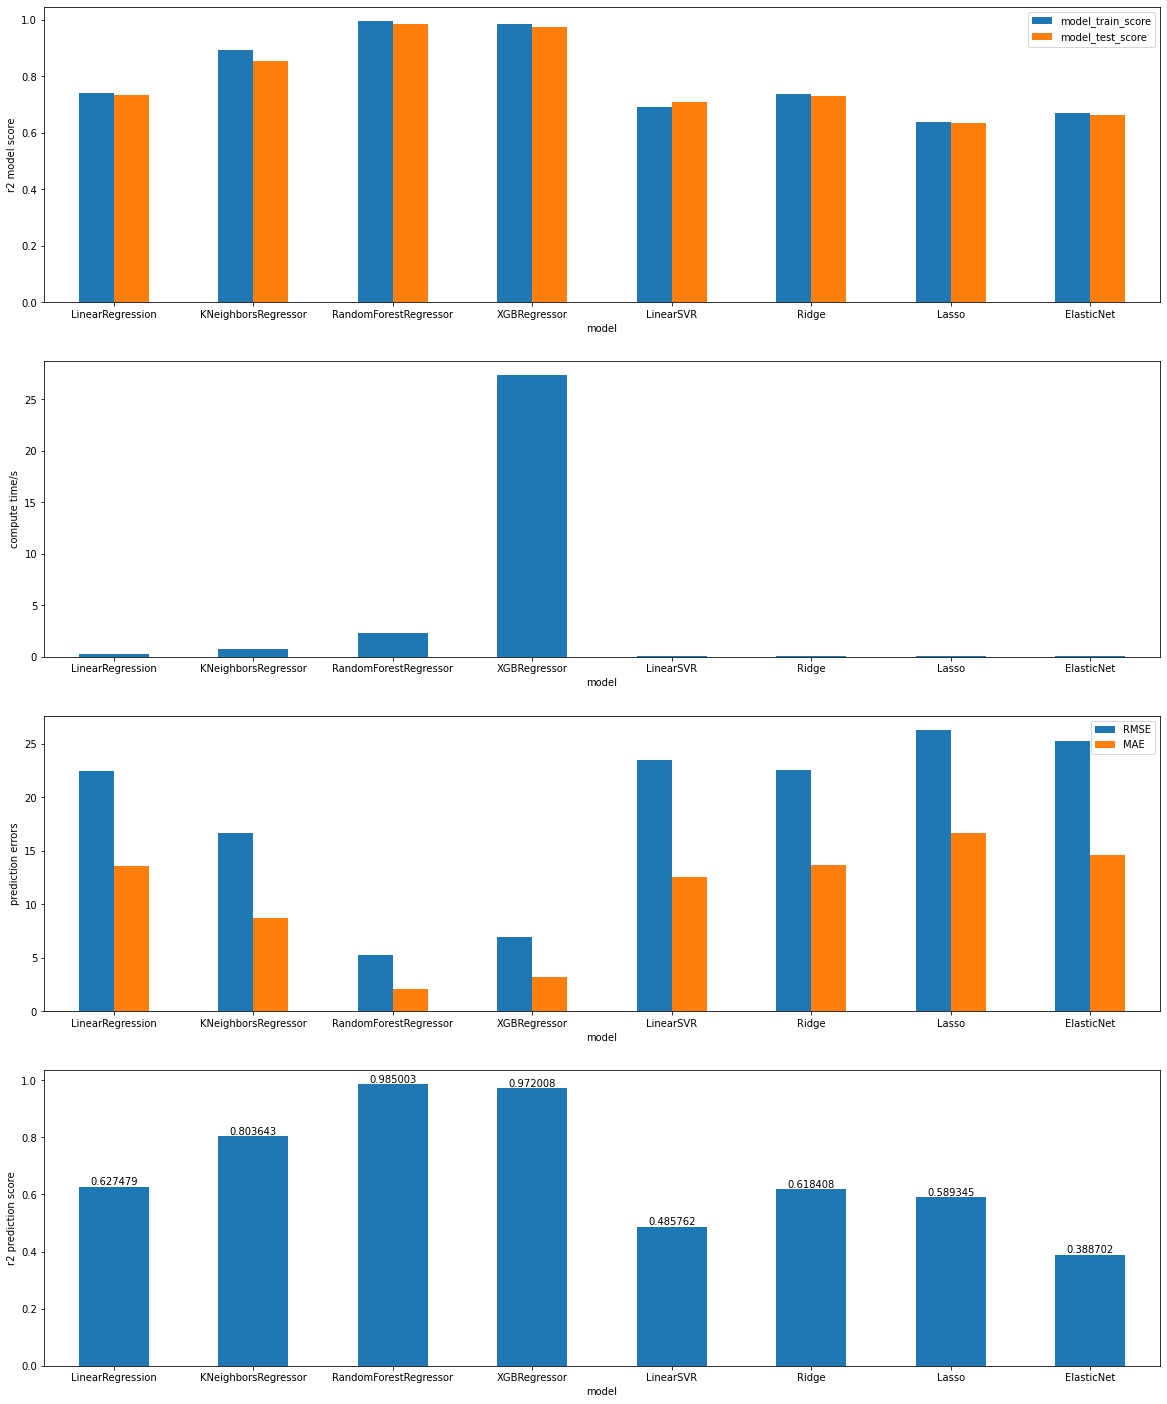

In [15]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(20, 25))

result[['model_train_score', 'model_test_score']].plot(
    rot=0, kind='bar', ylabel='r2 model score', ax=ax0)
result['compute_time'].plot(rot=0, kind='bar', ylabel='compute time/s', ax=ax1)
result[['RMSE', 'MAE']].plot(
    rot=0, kind='bar', ylabel='prediction errors',  ax=ax2)
result['R2'].plot(rot=0, kind='bar', ylabel='r2 prediction score',  ax=ax3)
for r in ax3.containers:
    ax3.bar_label(r)


## Model Choice

As we can see, with default hyper parameters, the most interesting model is RFR, because it's the one with the best ratio score / error / compute time.

In the next section we run this model with several hyper parameters and cv.

Please note, one could consider also:
* XGBoost: by far has the longest compute time, despite could provide good results, but most probably not a lot better than RFR because the improvement margin is tight
* KNR: has a pretty good compute time despite having a lower score. But, after several hyper parameters tuning, could potentially raise to acceptable thresholds



In [16]:
parameters_rf = {
    "preprocessor__num__imputer__strategy" : ["mean"],
    'regressor__n_estimators': [100, 300, 500],
    'regressor__min_samples_leaf': [1, 3, 5],
    'regressor__max_features': ['auto', 'sqrt', 'log2'],

    'regressor__max_depth' : [5, 15, 25, 50],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__bootstrap' : [True, False],
}

mod = ModelCompute(RandomForestRegressor(n_jobs=os.cpu_count()), parameters_rf)

start_time = datetime.now()
print(f'computing model {type(mod.model).__name__}...', end='')
ret = runModel(mod.model, mod.params)
print(f'done in {datetime.now() - start_time}')

computing model RandomForestRegressor...done.


In [17]:
ret['best_params']

{'preprocessor__num__imputer__strategy': 'mean',
 'regressor__bootstrap': True,
 'regressor__max_depth': 15,
 'regressor__max_features': 'auto',
 'regressor__min_samples_leaf': 1,
 'regressor__min_samples_split': 2,
 'regressor__n_estimators': 500}

## Predictions

In [8]:

from sklearn.ensemble import RandomForestRegressor

def predict_best_model(X_predict, _X_train=X_train, _y_train=y_train):   

    categorical_transformer = OneHotEncoder(handle_unknown="ignore")

    numeric_transformer = Pipeline(
        steps = [
                ("imputer", SimpleImputer(strategy='mean')),
                ("scaler", StandardScaler(with_mean=False))
            ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, selector(dtype_exclude="object")),
            ("cat", categorical_transformer, selector(dtype_include="object"))
        ]
    )

    regressor = RandomForestRegressor(
        n_jobs=os.cpu_count(),
        bootstrap=True,
        max_depth=15,
        max_features='auto',
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=500
        )

    reg = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("regressor", regressor)
         ]
    )

    reg.fit(_X_train, _y_train)
    return reg.predict(X_predict)

### Precision Visualization

0.021592890297100913


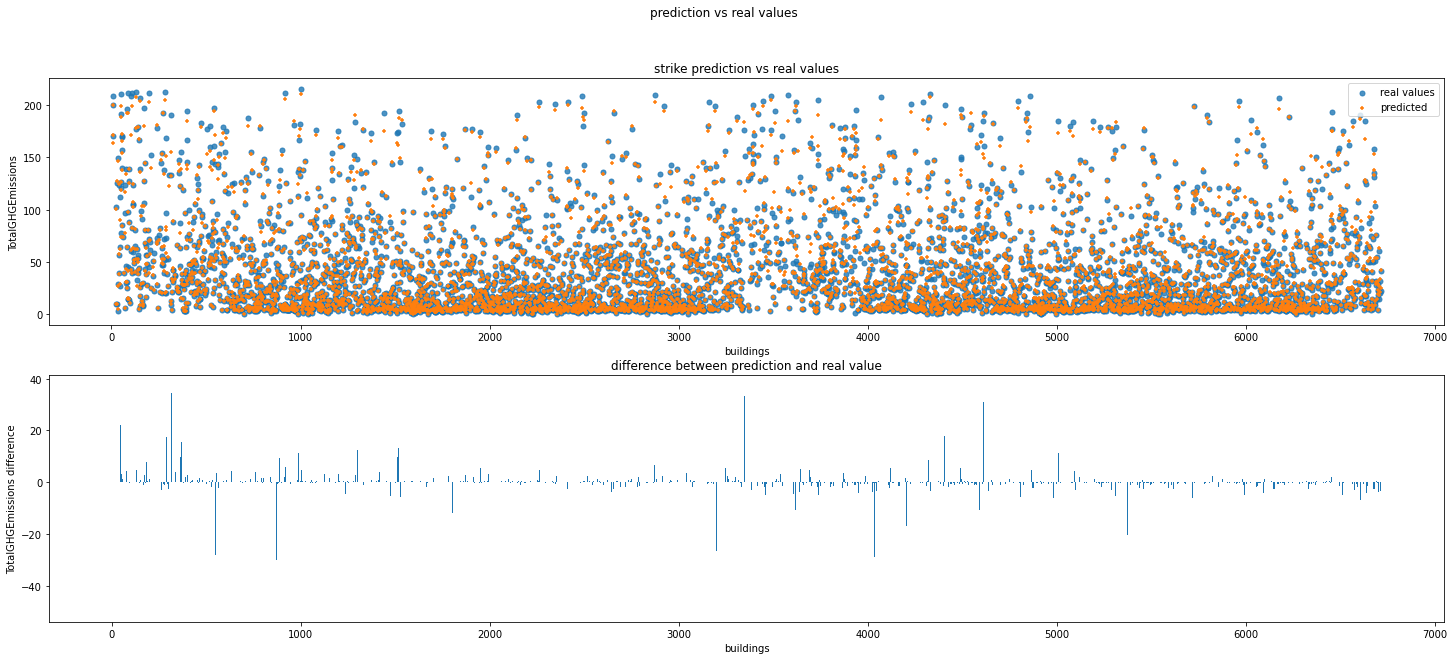

In [9]:
def show_strikes(_X_real, _y_real = y, show_graph=True, title='prediction vs real values'):
    
    y_pred = predict_best_model(_X_real)
    differences = _y_real-y_pred

    if show_graph:
        fig, ax = plt.subplots(2, 1, figsize=(25,10))
        fig.suptitle(title)
        ax[0].scatter(_y_real.index, _y_real.values, s=25, marker='o', alpha=0.8, label='real values')
        ax[0].scatter(_y_real.index, y_pred, s=20, marker='+', label='predicted')
        ax[0].set_xlabel('buildings')
        ax[0].set_ylabel('TotalGHGEmissions')
        ax[0].legend()
        ax[0].set_title('strike prediction vs real values')

        ax[1].bar(_y_real.index, differences)
        ax[1].set_xlabel('buildings')
        ax[1].set_ylabel('TotalGHGEmissions difference')
        ax[1].set_title('difference between prediction and real value')

    return differences

print(show_strikes(X).mean())


### Precision by Neighborhood

In [10]:
print(X.Neighborhood.unique())

byNeighborsResult = {}

for n in X.Neighborhood.unique():
    XbyNeighbor = X.groupby('Neighborhood').get_group(n)
    byNeighborsResult[n] = show_strikes(XbyNeighbor, y[XbyNeighbor.index], False)

by_neighbors = pd.DataFrame.from_dict(byNeighborsResult)


['DOWNTOWN' 'NORTHEAST' 'MAGNOLIA / QUEEN ANNE' 'LAKE UNION' 'BALLARD'
 'GREATER DUWAMISH' 'EAST' 'CENTRAL' 'DELRIDGE' 'SOUTHEAST' 'NORTHWEST'
 'NORTH' 'SOUTHWEST' 'North' 'Delridge' 'Ballard' 'Northwest' 'Central'
 'DELRIDGE NEIGHBORHOODS']


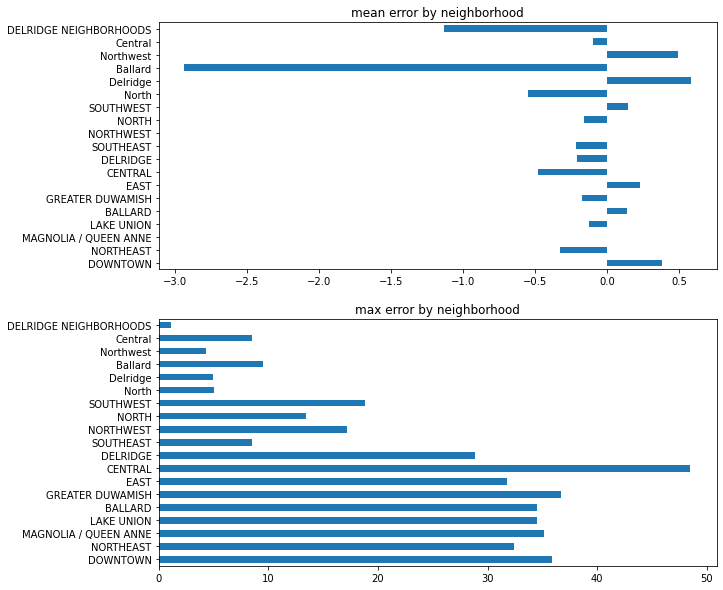

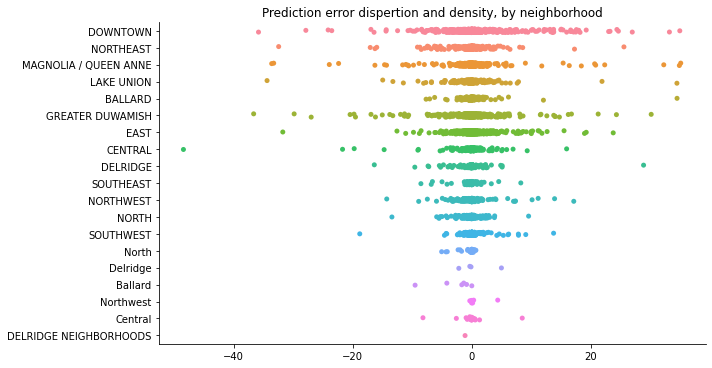

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))

by_neighbors.mean().plot(kind='barh', title='mean error by neighborhood', ax=ax[0])
by_neighbors.abs().max().plot(kind='barh', title='max error by neighborhood', ax=ax[1])
sns.catplot(data=by_neighbors, height = 5, aspect=2, orient='h').set(title='Prediction error dispertion and density, by neighborhood')

We can see our model: 
* tends to lower the reality
* is very efficient for some neighborhoods : delridge, central, northwest, ballard, north

### Precisions for Buildings' given characteristics 

* Building Type
* Gross Floor Area
* Number of Floors
* Distance

In [11]:
X

,BuildingType,PrimaryPropertyType,Neighborhood,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),GHGEmissionsIntensity,BuildingAge,Distance,NaturalGasRate
6,NonResidential,Hotel,DOWNTOWN,0.0,83008.0,Hotel,149.500000,6.252842e+06,2.37,89,0.436472,NaN
7,NonResidential,Other,DOWNTOWN,8.0,102761.0,Other - Entertainment/Public Assembly,152.200000,6.426022e+06,1.77,89,0.382852,0.071235
9,Multifamily MR (5-9),Mid-Rise Multifamily,DOWNTOWN,6.0,63712.0,Multifamily Housing,178.100000,4.587231e+06,2.51,105,0.387786,0.236417
23,NonResidential,Hotel,NORTHEAST,6.0,88592.0,Hotel,151.500000,3.880806e+06,1.04,14,3.654798,0.419013
25,NonResidential,Other,DOWNTOWN,2.0,67224.0,Automobile Dealership,64.900000,1.388717e+06,0.06,85,0.525677,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
6708,Nonresidential COS,Mixed Use Property,CENTRAL,1.0,20050.0,Other - Recreation,175.199997,1.813404e+06,NaN,22,1.538001,0.575686
6710,Nonresidential COS,Other,DELRIDGE NEIGHBORHOODS,1.0,18261.0,Other - Recreation,126.000000,9.320821e+05,1.11,34,5.001076,0.321559
6712,Nonresidential COS,Other,DOWNTOWN,1.0,16000.0,Other - Recreation,114.199997,9.502762e+05,2.01,12,0.996345,0.582704
6714,Nonresidential COS,Mixed Use Property,GREATER DUWAMISH,1.0,14101.0,Other - Recreation,105.300003,7.194712e+05,1.57,27,5.528963,0.515101


In [12]:
# By Building Type
byCategory = []

for b in X.BuildingType.unique():
    indexes = X.groupby('BuildingType').get_group(b).index.values
    y_real = y.loc[indexes]
    y_pred = predict_best_model(X.loc[indexes])
    res = {'type':b, 'numberOfRecords' : indexes.shape[0], 'RMSE' : np.sqrt(mean_squared_error(y_real, y_pred)), 'MAE' : mean_absolute_error(y_pred, y_real), 'R2' : r2_score(y_pred, y_real)}
    byCategory.append(res)

pd.DataFrame(byCategory)


,type,numberOfRecords,RMSE,MAE,R2
0,NonResidential,2147,4.231921,1.738309,0.991584
1,Multifamily MR (5-9),953,2.305411,0.907908,0.996887
2,SPS-District K-12,73,2.447774,1.015329,0.997142
3,Multifamily LR (1-4),1859,1.274833,0.366380,0.998397
4,Nonresidential COS,111,5.871019,2.930998,0.988499
5,Campus,20,7.648690,4.926014,0.971662
6,Multifamily HR (10+),94,6.682844,3.125635,0.979159
7,Nonresidential WA,1,1.279979,1.279979,NaN


In [22]:
# By Gross Floor Area
byCategory = []
slices = ['XS', 'S', 'M', 'L', 'XL', 'XXL']

c, bins = pd.cut(X['PropertyGFATotal'], 6, labels=slices, retbins=True)
print(bins)
for b in slices:
    indexes = c.to_frame().groupby('PropertyGFATotal').get_group(b).index.values
    y_real = y.loc[indexes]
    y_pred = predict_best_model(X.loc[indexes])
    res = {'PropertyGFATotal':b, 'numberOfRecords' : indexes.shape[0], 'RMSE' : np.sqrt(mean_squared_error(y_real, y_pred)), 'MAE' : mean_absolute_error(y_pred, y_real), 'R2' : r2_score(y_pred, y_real)}
    byCategory.append(res)

pd.DataFrame(byCategory)


[ 11116.54        39361.66666667  67438.33333333  95515.
 123591.66666667 151668.33333333 179745.        ]


,PropertyGFATotal,numberOfRecords,RMSE,MAE,R2
0,XS,2701,2.342356,0.673243,0.995363
1,S,1415,3.110444,1.176741,0.995181
2,M,539,4.162531,1.700521,0.990421
3,L,288,4.664917,2.284535,0.990960
4,XL,211,5.771682,2.927717,0.988222
5,XXL,104,6.233663,3.527206,0.984097


In [23]:
# By Number Of Floors
byCategory = []

for b in X.NumberofFloors.unique():
    indexes = X.groupby('NumberofFloors').get_group(b).index.values
    y_real = y.loc[indexes]
    y_pred = predict_best_model(X.loc[indexes])
    res = {'type':b, 'NumberofFloors' : indexes.shape[0], 'RMSE' : np.sqrt(mean_squared_error(y_real, y_pred)), 'MAE' : mean_absolute_error(y_pred, y_real), 'R2' : r2_score(y_pred, y_real)}
    byCategory.append(res)

pd.DataFrame(byCategory)

,type,NumberofFloors,RMSE,MAE,R2
0,0.0,128,6.705518,3.344851,0.984033
1,8.0,74,3.688035,1.763401,0.991028
2,6.0,469,3.597378,1.344659,0.992844
3,2.0,703,3.344180,1.340025,0.994153
4,5.0,464,2.083593,0.786107,0.997480
5,3.0,1210,2.810951,0.862800,0.994185
6,4.0,1254,2.846300,0.789346,0.994308
7,7.0,192,3.113331,1.621665,0.995297
8,1.0,744,3.869893,1.520739,0.993681
9,9.0,20,3.839554,2.134494,0.991649


In [17]:
# By Gross Floor Area
byCategory = []
slices = ['0', '1', '2', '3', '4', '5']

c = pd.qcut(X['Distance'], 6, labels=slices)

for b in slices:
    indexes = c.to_frame().groupby('Distance').get_group(b).index.values
    y_real = y.loc[indexes]
    y_pred = predict_best_model(X.loc[indexes])
    res = {'Distance':b, 'numberOfRecords' : indexes.shape[0], 'RMSE' : np.sqrt(mean_squared_error(y_real, y_pred)), 'MAE' : mean_absolute_error(y_pred, y_real), 'R2' : r2_score(y_pred, y_real)}
    byCategory.append(res)

pd.DataFrame(byCategory)

,Distance,numberOfRecords,RMSE,MAE,R2
0,0,877,4.427123,1.952489,0.991488
1,1,876,3.931659,1.361621,0.991891
2,2,876,3.116056,1.059981,0.994138
3,3,876,2.911687,0.960546,0.994520
4,4,876,2.378932,0.809622,0.996294
5,5,877,1.957924,0.723470,0.997804


### Precision depending of GHGEmissions range

We evaluate the strike of our model for different range of GHGEmissions

average LOW difference:  0.5964338844801905
average MID difference:  2.573322825956111
average HIGH difference:  6.5782740240402715


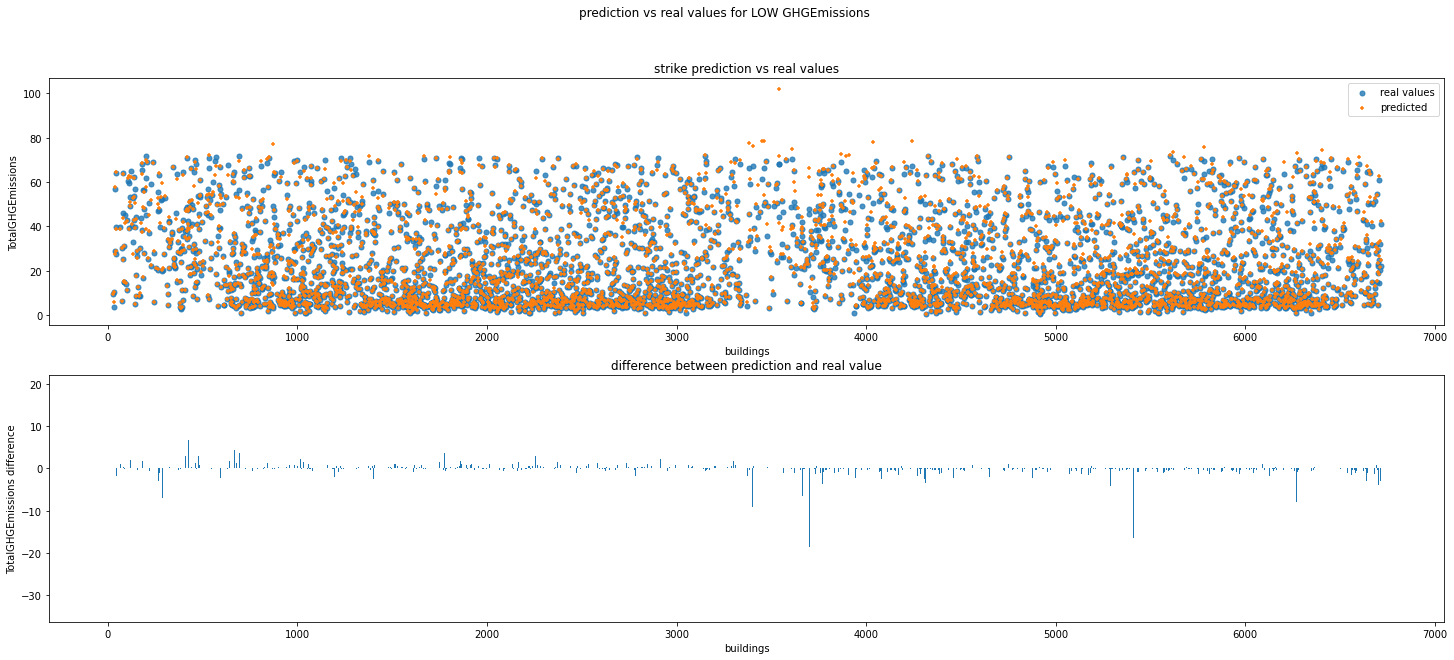

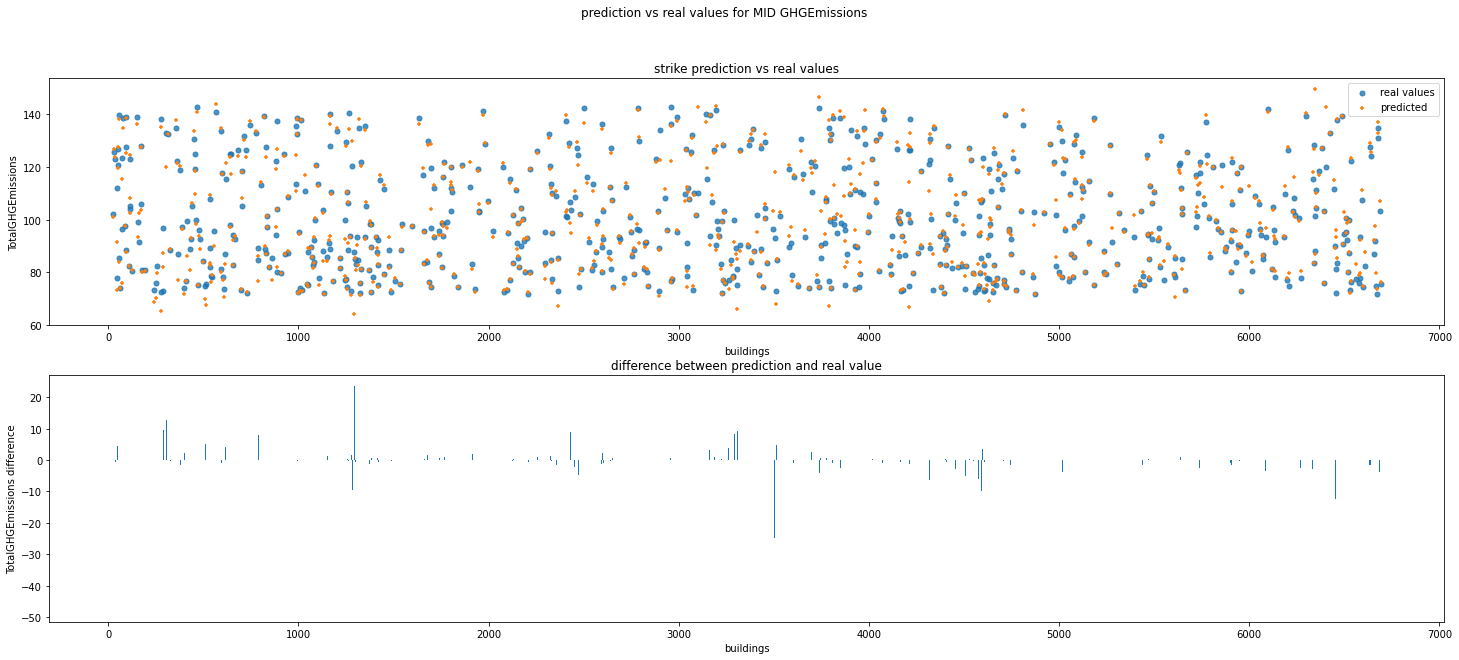

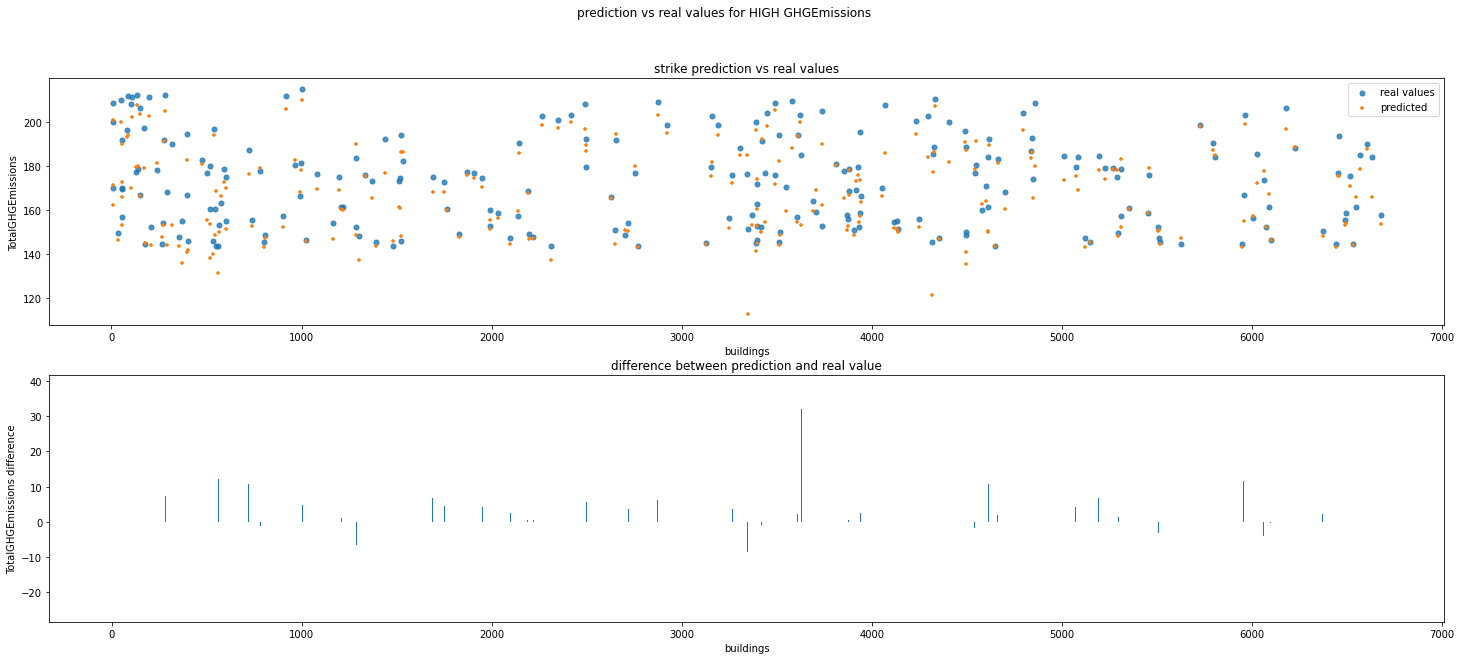

In [15]:

slices = ['low', 'mid', 'high']

c = pd.cut(y, 3, labels=slices)

indexes_low = c.to_frame().groupby('TotalGHGEmissions').get_group('low').index.values
X_low = X.loc[indexes_low]
y_low = y.loc[indexes_low]
low_diff = show_strikes(X_low, y_low, True, 'prediction vs real values for LOW GHGEmissions')
print('average LOW difference: ', low_diff.abs().mean())


indexes_mid = c.to_frame().groupby('TotalGHGEmissions').get_group('mid').index.values
X_mid = X.loc[indexes_mid]
y_mid = y.loc[indexes_mid]
mid_diff = show_strikes(X_mid, y_mid, True, 'prediction vs real values for MID GHGEmissions')
print('average MID difference: ', mid_diff.abs().mean())


indexes_high = c.to_frame().groupby('TotalGHGEmissions').get_group('high').index.values
X_high = X.loc[indexes_high]
y_high = y.loc[indexes_high]
high_diff = show_strikes(X_high, y_high, True, 'prediction vs real values for HIGH GHGEmissions')
print('average HIGH difference: ', high_diff.abs().mean())

## Conclusion

Our model tends to be more precise for low values of TotalGHGEmissions.

At the opposite, for hig values the model performs approx. 10 times lower.

To recap, in a real situation we would like to detect the buildings generating high GHG values. 

Thanks to our model, we'll be able to predict those values, knowing that for high results it tends to produce a figure slightly behind the reality, especially for particular neighborhoods

# APPENDIX

In [27]:
# Gramm matrix - WIP recupérer X apres nettoyage

from sklearn import metrics
import matplotlib

def gram():
    
    kmatrix = metrics.pairwise.rbf_kernel(X_train[X_train.select_dtypes(exclude='object').columns], gamma=0.01)
    kmatrix100 = kmatrix[:100, :100]
    # dessiner la matrice
    plt.pcolor(kmatrix100, cmap=matplotlib.cm.PuRd)

    # rajouter la légende
    plt.colorbar()

    # retourner l'axe des ordonnées
    plt.gca().invert_yaxis()
    plt.gca().xaxis.tick_top()

    # afficher l'image
    plt.show()


Reading list : 

https://towardsdatascience.com/how-to-differentiate-between-scaling-normalization-and-log-transformations-69873d365a94

https://en.wikipedia.org/wiki/Multicollinearity

https://en.wikipedia.org/wiki/Ordinary_least_squares

https://en.wikipedia.org/wiki/Occam%27s_razor

https://en.wikipedia.org/wiki/Minimum_description_length

https://towardsdatascience.com/features-correlations-data-leakage-confounded-features-and-other-things-that-can-make-your-deep-771bcaf84f9f

https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables

https://machinelearningmastery.com/data-leakage-machine-learning/

https://towardsdatascience.com/what-are-rmse-and-mae-e405ce230383

https://towardsdatascience.com/guide-to-encoding-categorical-features-using-scikit-learn-for-machine-learning-5048997a5c79

https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

very important article why to normalize features: https://towardsdatascience.com/how-to-differentiate-between-scaling-normalization-and-log-transformations-69873d365a94

Notes personnelles : 

data leakage, à cause de la corrélation entre features, le fait de bouger un peu une feature, va non seulement influencer le resultat mais aussi les features elles memes, donc la prédiction sera plus aléatoire

scaling, normalisation, : à ne faire que sur le train set

transformation : à faire sur train et test set

certaines features ne suivent pas des distributions normales, mais on peut les transformer pour y parvenir: 
